# Final Report: Analysis On Factors Leading to Obesity in America
## Project Introduction
With obesity at all time rates in the United States it is important to understand the individuals most at risk. This analysis is focused on the critical issue of obesity among individuals in America, exploring data from selected population characteristics. This information was made available by the Centers of Disease Control and Prevention (CDC). Our goals are to investigate if race plays a role in being at risk of obesity, if income is the leading factor in obesity, and to explore other interesting relationships found within the data. 

**Github Repository**: https://github.com/uic-cs418/group-project-mind-masters

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
from obesity_children import * #cleaning python file
import data1_helper # for analyzing data 1
from obesity_visualization import update_plot, load_and_prepare_data # Asian / Races graph
from ipywidgets import interact, Dropdown, fixed

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from inactivity_model import train_model, evaluate_model, predict_inactivity, baseline_model

df = pd.read_csv('physicaldataset2.csv')

## Reading Data / Cleaning Data
**Data - Obesity Among Children and Adolescents 2-19**

**Data - Obesity Among Adults 20+**

In [14]:
obesity_adult = pd.read_csv("Normal_weight__overweight__and_obesity_among_adults_aged_20_and_over__by_selected_characteristics__United_States.csv")
panelDict, unitDict, stubNameDict, stubLabelDict, yearDict, ageDict = data1_helper.getMapping(obesity_adult)
raceGender_df = data1_helper.cleanGenderRace(obesity_adult)
age_df = data1_helper.cleanAge(obesity_adult)
raceGender_df.head()

,INDICATOR,PANEL,PANEL_NUM,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,SE,FLAG,Gender,Race
49,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Sex and race and Hispanic origin,4,Male: Not Hispanic or Latino: White only,3.111,2015-2018,10,20 years and over,1.0,23.4,1.4,.,Male,White
59,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Sex and race and Hispanic origin,4,Female: Not Hispanic or Latino: White only,3.112,2015-2018,10,20 years and over,1.0,31.9,1.7,.,Female,White
79,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Sex and race and Hispanic origin,4,Male: Not Hispanic or Latino: Black or African...,3.121,2015-2018,10,20 years and over,1.0,26.4,1.7,.,Male,Black or African American
89,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Sex and race and Hispanic origin,4,Female: Not Hispanic or Latino: Black or Afric...,3.122,2015-2018,10,20 years and over,1.0,19.2,1.2,.,Female,Black or African American
109,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Sex and race and Hispanic origin,4,Male: Not Hispanic or Latino: Asian only,3.131,2015-2018,10,20 years and over,1.0,41.9,1.7,.,Male,Asian


**Data - Nutrition, Physical Activity, and Obesity**

In [15]:
df = df.drop(['Data_Value_Unit', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'DataValueTypeID', 'QuestionID', 'TopicID', 'ClassID'], axis=1)

df = df.dropna(subset=['GeoLocation'])

df = df.dropna(subset=['Data_Value'])

df = df.dropna(subset=['Age(years)', 'Gender', 'Race/Ethnicity'], how='all')

for column in ['Age(years)', 'Gender', 'Race/Ethnicity', 'Income']:
    df[column] = df[column].fillna('Missing Data')

year_comparison = (df['YearStart'] == df['YearEnd']).all()
if year_comparison:
    # Drop YearEnd if it's always the same as YearStart
    df = df.drop('YearEnd', axis=1)

print(df.shape)

print(df.columns.tolist())

print(df.head())

print(f"Final dataset shape: {df.shape} (rows, columns)")

print(f"Total number of rows after cleaning: {df.shape[0]}")

(43274, 25)
['YearStart', 'LocationAbbr', 'LocationDesc', 'Datasource', 'Class', 'Topic', 'Question', 'Data_Value_Type', 'Data_Value', 'Data_Value_Alt', 'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Income', 'Race/Ethnicity', 'GeoLocation', 'LocationID', 'StratificationCategory1', 'Stratification1', 'StratificationCategoryId1', 'StratificationID1']
    YearStart LocationAbbr  LocationDesc  \
5        2015           GU          Guam   
6        2012           WY       Wyoming   
9        2011           AL       Alabama   
11       2015           RI  Rhode Island   
14       2020           DE      Delaware   

                                    Datasource                    Class  \
5   Behavioral Risk Factor Surveillance System        Physical Activity   
6   Behavioral Risk Factor Surveillance System  Obesity / Weight Status   
9   Behavioral Risk Factor Surveillance System  Obesity / Weight Status   
11  Behavioral Ris

## Machine Learning Analysis
**Linear Regression Model**

**Question**: Based on the trend of the rate of obesity of adult in the US between 1988 and 2018, what will be the rate of obesity in the US in 2024?

In [16]:
from scipy import stats
import sklearn.metrics as sm

# prepare data for ML
middleYearDict = data1_helper.getMiddleYear(yearDict)  
generalObesity = data1_helper.getFilteredData(obesity_adult, 1, 3, 1, 1.1, middleYearDict)
x = generalObesity["MiddleYear"]
y = generalObesity["ESTIMATE"]

In [17]:
# baseline ML model: mean
baselineML = data1_helper.MeanModel()
data1_helper.fitAndEvaluate(baselineML, x, y)

mean squared error:  22.442400000000003


In [18]:
# linear regression model
linRegressML = data1_helper.LinearRegressionModel()
data1_helper.fitAndEvaluate(linRegressML, x, y)

mean squared error:  0.5901431713657087


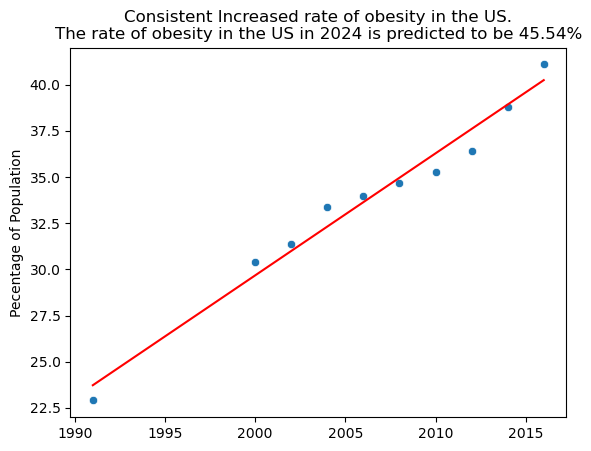

In [19]:
data1_helper.plotML(generalObesity, linRegressML, x) # plot data and best fit line

**Comment:** The linear regression outperforms the baseline model with mean squared error = 1. The model predicts that in 2024, 45.54% of the population in US are obese. The result is reasonable in the fact that the rate of obesity always increases according to our data and 2024 is close to this year range 1988-2018 so it is safe to predict based on this trend.

**Logistic Regression**

In [20]:
# Train the model
lr_model, X_test, y_test = train_model(df)
# Evaluate the model
evaluate_model(lr_model, X_test, y_test)
# Create sample inputs for different types of individuals
sample_inputs = [
    {"Age(years)": "25 - 34", "Gender": "Male", "Race/Ethnicity": "Non-Hispanic White"},
    {"Age(years)": "45 - 54", "Gender": "Female", "Race/Ethnicity": "Non-Hispanic Black"},
    {"Age(years)": "65 or older", "Gender": "Male", "Race/Ethnicity": "Hispanic"},
]
# Predict inactivity for sample inputs
predict_inactivity(lr_model, sample_inputs)
# Evaluate the baseline model
y_pred = lr_model.predict(X_test)
baseline_model(y_test, y_pred)

Accuracy: 0.80
Confusion Matrix:
[[1274   41]
 [ 304   76]]

Sample Input 1:
Age: 25 - 34
Gender: Male
Race/Ethnicity: Non-Hispanic White
Predicted Inactivity: Active

Sample Input 2:
Age: 45 - 54
Gender: Female
Race/Ethnicity: Non-Hispanic Black
Predicted Inactivity: Inactive

Sample Input 3:
Age: 65 or older
Gender: Male
Race/Ethnicity: Hispanic
Predicted Inactivity: Inactive

Baseline Accuracy: 0.22418879056047197
Baseline Confusion Matrix:
[[   0 1315]
 [   0  380]]

Logistic Regression Accuracy: 0.7964601769911505
Logistic Regression Confusion Matrix:
[[1274   41]
 [ 304   76]]


In [1]:
# Testing the Logistic Regression ML - confusion matrix plot

In [ ]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# Create a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Logistic Regression ML - Visulazation Plot

In [ ]:
race_activity = activity_df.groupby('Race/Ethnicity')['Inactive'].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=race_activity.index, y=race_activity.values)
plt.xlabel('Race/Ethnicity')
plt.ylabel('Inactivity Percentage')
plt.title('Inactivity Percentage by Race/Ethnicity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Visualizations + Additional Visualization
**Wealthy adults in 2018 are more likely to be obese than Low-Income Adults in 1988**

**Hispanic individuals aged 2-19 have the highest obesity rate from 1988-2018**

**Asians have less obesity rate than people of other races in all levels of Obesity**


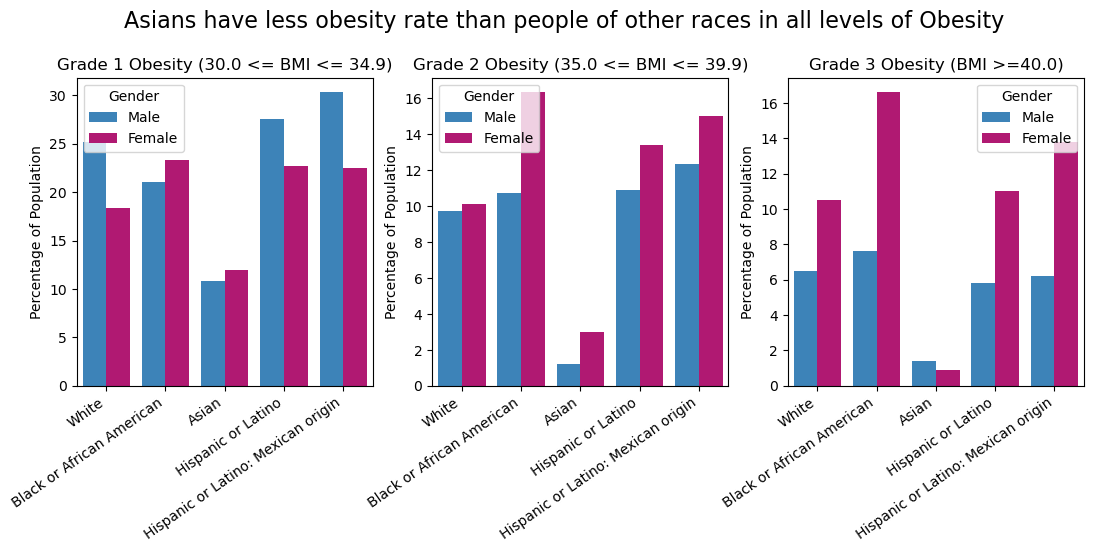

In [4]:
data1_helper.obesityRaceVsObesity(raceGender_df)

**Description:** We created this visualization to test the hypothesis that Asians have a lower obesity rate than other races, the visualization shows that Asians have a lower obesity level than other races in all 3 different types of obesity:

Obesity grade 1: 10% asians have grade 1 obesity and other races average is around 20%;

Obesity grade 2: 4% of Asians have grade 2 obesity and other races average is around 10%;

Obesity grade 3: 1% of Asians have grade 3 obesity and other races average is around 9%

**Interactive Visualization**

Directions on how to access interactive visualization in README.

In [5]:
# Load data
concatenated_df = load_and_prepare_data()

races_with_total = concatenated_df['Race/Ethnicity'].dropna().unique()
race_dropdown = Dropdown(options=races_with_total, description="Select Race:")
interact(update_plot, race=race_dropdown, concatenated_df=fixed(concatenated_df))

interactive(children=(Dropdown(description='Select Race:', options=('American Indian/Alaska Native', 'Other', …

<function obesity_visualization.update_plot(race, concatenated_df)>

## Results
Fully explain and analyze the results from your data, i.e. the inferences or correlations you uncovered, the tools you built, or the visualizations you created. 